In [169]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
from math import exp, sqrt, pi
from scipy.optimize import fsolve
from scipy.special import erf, erfc
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [170]:
# Loading variables from "Data load.ipynb"
with open('variabler.pkl', 'rb') as f:
    countries, maturity, Interest_rates, ALP1, ALP2, ALP3, ALP4, ALP5, ALP6,  MDY, SY, RHO, SE, BSY, DY = pickle.load(f)  

######################################## Variables in "variabler.pkl" ########################################
# Countries         — List of the 26 countries in EUROSTAT order for each country
# Interest_rates    — Interest rates for AAA-ranked countries with different maturities for each country
# ALP1              — Maximum primary surplus across the entire period for each country
# ALP2              — Maximum (income) - Maximum (expenditure) across the entire period for each country
# ALP3              — Average of the dentire period for each country
# ALP4              — Time-varying (Actual) for each country
# ALP5              — 80th percentile for each country
# ALP6              — HP filter for each country
# MDY               — Mean of first GDP differences for each country
# SY                — Standard deviation of Simulated Paths
# RHO               — AR(1) parameter
# SE                — Standard errors for each country
# BSY               — Debt to GDP ratio for each country
# DY                — GDP differences for each country

In [171]:
# Setting variables
N = len(ALP1)           # Number of countries
initial_guess = -0.5      # Initial guess for minimization function
num_points = 10000      # Simulation parameter (linspace)
#maturity = 2            # Maturity period
T_0_new = 2000          # Initial year   
T_new = 2022            # End year   

In [172]:
# Dictionaries and Arrays:

interest_rate_time_model = {}
interest_rate_mean_model = {}

ALPHA_cont ={}
ALPHA_max = {}
ALPHA_mean = {}
ALPHA_time = {}
interest_rate_0 ={}
interest_rate_1 = {}
interest_rate_2 = {}
interest_rate_3 = {}
alpha_list = {0: {}, 1: {}, 2: {}, 3: {}}  # Initialize each key as an empty dictionary
interest_rate_list = {0: {}, 1: {}, 2: {}, 3: {}}  # Initialize each key as an empty dictionary

alpha = {}
se_g = {}
g_bar_log = {}
g_bar = {}
z_opt = {}
F_CDF = {}
# EBn = {}
# EBe = {}
MSB = {}
MSD = {}
z = {}
interest_rate = {}
BSYobs = {}
Probability_of_default_MSD = {}
Probability_of_default = {}


Var_output = np.zeros((N, 4))
results = np.zeros((N, 3))
results_2 = np.zeros((N, 3))
D = {}
Fm = [[] for _ in range(N)]
Laffer = [[] for _ in range(N)]
smpl1 = [year for year in range(T_0_new, T_new)]
smpl2 = [year for year in range(T_0_new, T_new+1)]
ALP = {}
DATA = []
resm = []  
resb = []  

In [173]:
# Choosing the interest rate based on the maturity 
interest_rate_time = Interest_rates[maturity] 
#interest_rate_time = interest_rate_time.apply(lambda x: 0.02 if x < 0.02 else x)

# Calculate the average interest rate, adjusting for compounding over the maturity period
interest_rate_mean_model = np.mean(interest_rate_time)
interest_rate_mean_model = ((1+interest_rate_mean_model)**(maturity))-1

# Calculate time-varying interest rates, adjusting each rate for compounding over the maturity period
for t in range(0,len(interest_rate_time)):
    interest_rate_time_model[t] = ((1+interest_rate_time[t])**(maturity))-1

# Rename 'BSY' values to 'Debt_ratio' for each country
Debt_ratio = {}
for i in range(0, len(BSY)):
    Debt_ratio[countries[i]] = BSY[countries[i]]

# Set different scenarios for primary surplus (alpha) and interest rate
for i in range(0,len(countries)):
    alpha_list[0][countries[i]] = np.zeros((len(smpl2))) + 0.05
    alpha_list[1][countries[i]] = np.zeros((len(smpl2))) + 0.05
    alpha_list[2][countries[i]] = np.zeros((len(smpl2))) + 0.05
    alpha_list[3][countries[i]] = np.zeros((len(smpl2))) + 0.05 #np.mean(list(ALP1.values())) #ALP6[countries[i]] #


for i in range(0,len(countries)):
    interest_rate_list[0][countries[i]] = np.zeros((len(smpl2))) + interest_rate_mean_model
    interest_rate_list[1][countries[i]] = np.zeros((len(smpl2))) + interest_rate_mean_model
    interest_rate_list[2][countries[i]] = np.zeros((len(smpl2))) + interest_rate_mean_model
    interest_rate_list[3][countries[i]] = np.zeros((len(smpl2))) + interest_rate_mean_model #list(interest_rate_time_model.values())


In [174]:
# Minimization function (CDF/PDF)

def solve_iid(z, sigma):
    cdf = (1 + erf(z / sqrt(2))) / 2        # Compute the cumulative distribution function (CDF) for a standard normal at z.
    pdf = exp(-z**2 / 2) / sqrt(2 * pi)     # Compute the probability density function (PDF) for a standard normal at z.
    res = sigma * (1 - cdf) - pdf           # Calculate the result based on sigma and adjustments for CDF and PDF.
    return res                              # Return the computed value.


In [175]:
# Main model
for j in range(0,len(alpha_list)):
    # Different scenarios for primary surplus (alpha) and interest rate
    ALPHA_LIST_var = alpha_list[j]
    INTEREST_RATE_LIST_var = interest_rate_list[j]

    for i in range(0, len(countries)):
        ############################################################ CONSTANT/MEAN/LAST/VALUE MODEL  ##################################
        ############################################################ Setting the parameters/variable ##################################
        alpha[countries[i]] = ALPHA_LIST_var[countries[i]]
        interest_rate[countries[i]] = INTEREST_RATE_LIST_var[countries[i]]
        se_g[countries[i]] = SY[countries[i]]
        g_bar[countries[i]] = np.log(1+MDY[countries[i]])     #maturity * 
        #print(countries[i],"          ",np.log(1+MDY[countries[i]]),"         ",np.log(1+maturity*MDY[countries[i]]),"     ",maturity*np.log(1+MDY[countries[i]]))

        ############################################################ MODEL ############################################################
        z_opt[countries[i]] = fsolve(lambda Gs1: solve_iid(Gs1, se_g[countries[i]]), initial_guess)


        F_CDF[countries[i]] = (1+erf(z_opt[countries[i]]/sqrt(2)))/2

        MSB[countries[i]] = np.mean(alpha[countries[i]]) * exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1 - F_CDF[countries[i]]) / (1 + np.mean(interest_rate[countries[i]]) - exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1 - F_CDF[countries[i]]))

        MSD[countries[i]] = exp(g_bar[countries[i]]+se_g[countries[i]]*z_opt[countries[i]])*(np.mean(alpha[countries[i]])+MSB[countries[i]])
        
        z[countries[i]] = (np.log(0.01*(Debt_ratio[countries[i]].iloc[-1]/maturity)/(np.mean(alpha[countries[i]])+MSB[countries[i]]))-g_bar[countries[i]])/(se_g[countries[i]])
        ###### Orginal ovenfor:
        #z[countries[i]] = (np.log((0.01*Debt_ratio[countries[i]].iloc[-1])/(np.mean(alpha[countries[i]])+maturity*MSB[countries[i]]))-g_bar[countries[i]])/(se_g[countries[i]]/maturity)
        

        if np.all(np.imag(z[countries[i]]) == 0):
            Probability_of_default[countries[i]] = 1-(1-(1+erf(z[countries[i]]/sqrt(2)))/2) ** (1/maturity)
        else:
            Probability_of_default[countries[i]]=np.nan
    


        ############################################################ CONSTANT/MEAN/LAST/VALUE MODEL OUTPUT ############################
        Var_output[i, 0] = 100 * np.mean(alpha[countries[i]])
        Var_output[i, 1] = 100 * g_bar[countries[i]] / 4
        Var_output[i, 2] = 100 * SY[countries[i]]
        Var_output[i, 3] = Debt_ratio[countries[i]].iloc[-1]
        results[i, 0] = 100 * maturity * MSD[countries[i]]
        results[i, 2] = 100 * Probability_of_default[countries[i]]
        results_2[i, 1] = 100 * maturity * MSB[countries[i]] 

        ############################################################ TIME MODEL #######################################################
        ############################################################ Setting the parameters/variable ##################################
        MSB[countries[i]] = []
        z[countries[i]] = [0] * len(smpl2)
        MSD[countries[i]] = [0] * len(smpl2)     
        Probability_of_default[countries[i]] = [0] * len(smpl2)     
        
        ############################################################ MODEL ############################################################
        for t in range(0,len(smpl2)):
            
            MSB[countries[i]].append(alpha[countries[i]][t] * exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1-F_CDF[countries[i]]) / (1 + interest_rate[countries[i]][t] - exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1-F_CDF[countries[i]])))

            MSD[countries[i]][t] = exp(g_bar[countries[i]]+se_g[countries[i]]*z_opt[countries[i]])*(alpha[countries[i]][t])+MSB[countries[i]]

            z[countries[i]][t] = (np.log((0.01 * BSY[countries[i]].values[t]/maturity) / (alpha[countries[i]][t] + MSB[countries[i]][t])) - g_bar[countries[i]]) / (se_g[countries[i]])
            ###### Orginal ovenfor:
            #z[countries[i]][t] = (np.log(0.01 * BSY[countries[i]].values[t]/(alpha[countries[i]][t]+maturity*MSB[countries[i]][t]))-g_bar[countries[i]])/(se_g[countries[i]]/maturity)
            
            if np.all(np.imag(z[countries[i]][t]) == 0):
                Probability_of_default[countries[i]][t] = 1-(1-(1+erf(z[countries[i]][t]/sqrt(2)))/2) ** (1/maturity)
            else:
                Probability_of_default[countries[i]][t]=np.nan
        
            Probability_of_default[countries[i]][t] = 100 * Probability_of_default[countries[i]][t]
        
        ############################################################ TIME MODEL OUTPUT ################################################
        DATA.append((np.arange(T_0_new, T_new + 1), 100*maturity*MSD[countries[i]][len(smpl2)-1], Probability_of_default[countries[i]]))

    resm.append(results.copy()) 
    
    resb.append(results_2.copy()) 

In [176]:
dfs = []
alphas = [0,1,2,3] 

for i in range(len(resm)):
    dff = pd.DataFrame(resm[i])
    suffixes = [f"MSD (Alpha_{alphas[i]})", f"Probability_of_default_MSD (Alpha_{i})", f"Probability_of_default (Alpha_{i})"]
    dff.columns = suffixes  
    dfs.append(dff)

    df_merged = dfs[0]
    for i in range(1, len(dfs)):
        df_merged = df_merged.join(dfs[i], how='right')
        df_merged = df_merged.round(3)

    df_resm = df_merged

df_resm.index = [countries[i] for i in range(len(countries))]
df_resm.drop(df_resm.columns[[1,4,7,10]], axis=1, inplace=True)

In [177]:
dfs = []
alphas = [0,1,2,3]  

for i in range(len(resb)):
    dff = pd.DataFrame(resb[i])
    suffixes = [f"MSD (Alpha_{i})", f"Probability_of_default_MSD (Alpha_{i})", f"Probability_of_default (Alpha_{i})"]
    dff.columns = suffixes  
    dfs.append(dff)

    df_merged = dfs[0]
    for i in range(1, len(dfs)):
        df_merged = df_merged.join(dfs[i], how='right')
        df_merged = df_merged.round(3)

    df_resb = df_merged

df_resb.index = [countries[i] for i in range(len(countries))]    


******
<h2><center>Plots</center></h2>

******

In [178]:
# Redefine DATA to make it suitable for plotting
dataframes = {}
combined_df = {}

# Loop through the DATA list and create a DataFrame for each entry
for i in range(len(DATA)):
    # Creating DataFrame with 'Year', 'MSD', and 'Probability_of_default'
    dff = pd.DataFrame({'Year': DATA[i][0], 
                        'MSD': [item[0] for item in DATA[i][1]], 
                        'Probability_of_default': [item[0] for item in DATA[i][2]]})   

    dataframes[i] = dff
        
# Merge DataFrames to combine data for different alpha and interest rates scenarios for each country
for i in range(len(countries)):
    temp_df = dataframes[i].merge(dataframes[i+len(countries)], how='right', on="Year", suffixes=(' (Alpha_0)', ' (Alpha_1)'))
    temp_df = temp_df.merge(dataframes[i+len(countries)*2], how='right', on="Year", suffixes=(' (Alpha_1)', ' (Alpha_2)'))
    temp_df = temp_df.merge(dataframes[i+len(countries)*3], how='right', on="Year", suffixes=(' (Alpha_2)', ' (Alpha_3)'))
    temp_df = temp_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    temp_df = temp_df.round(3)
    combined_df[countries[i]] = temp_df

In [179]:
# Setting the plots parameters
Close_plots = False
Save_plots = False
path = "/Users/sebastianhejbergingesen/Documents/Københavns Universitet/Økonomi/2023-2025 Kandidat/8.Semester/Seminar – Topics in Sovereign Debt/Model/Plot"

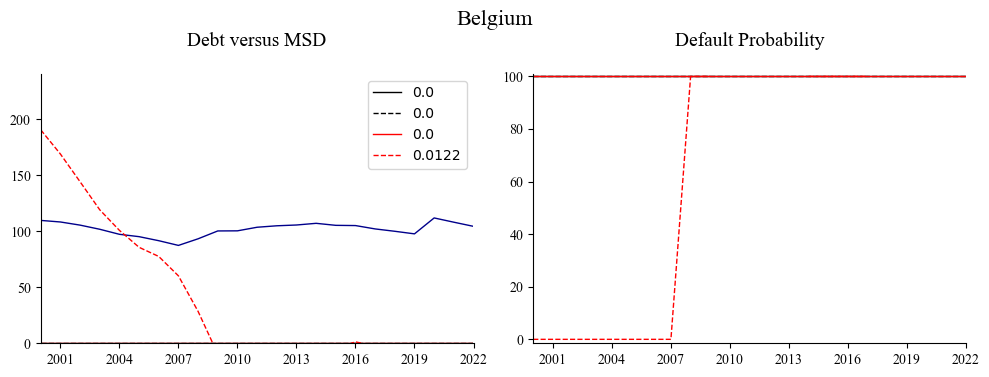

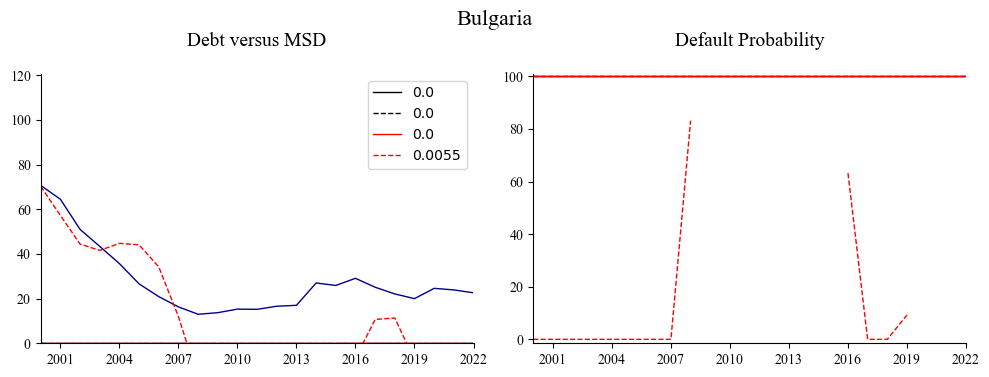

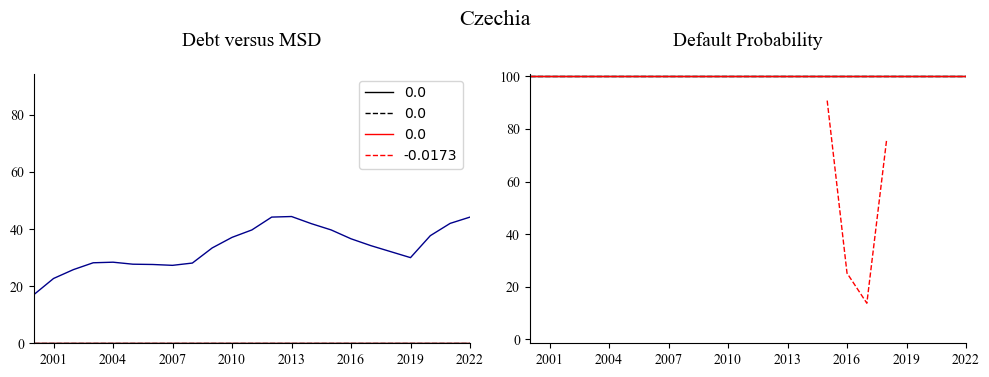

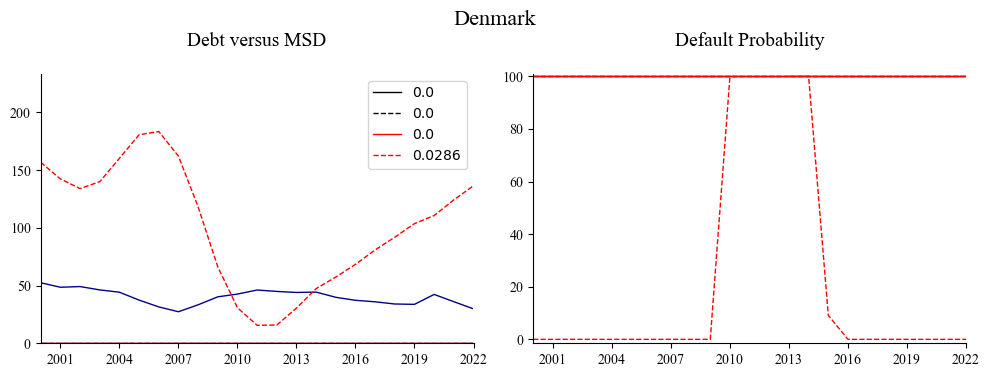

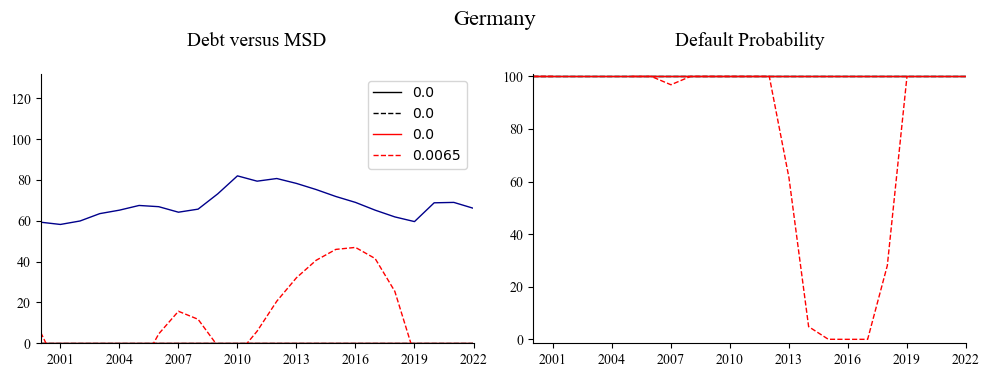

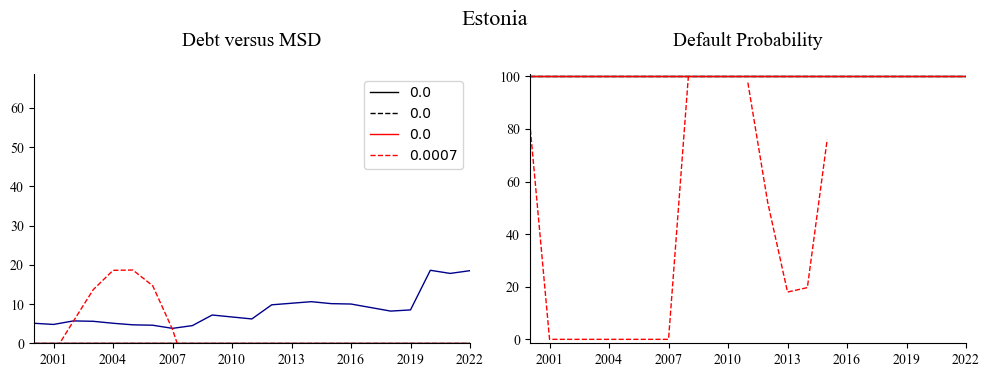

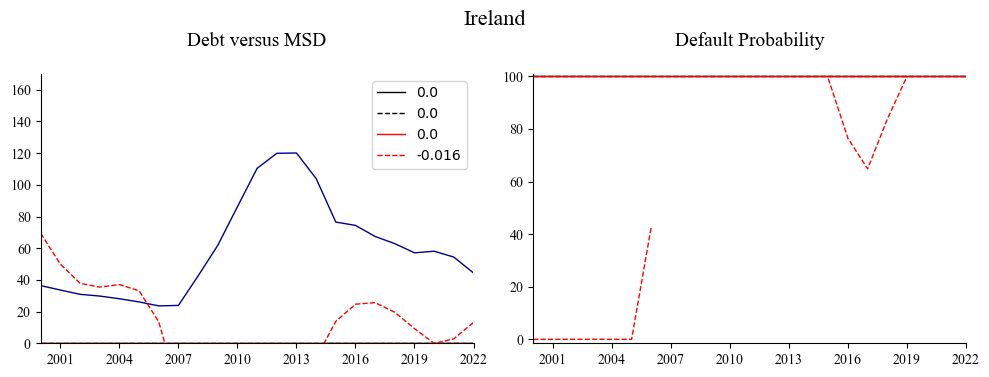

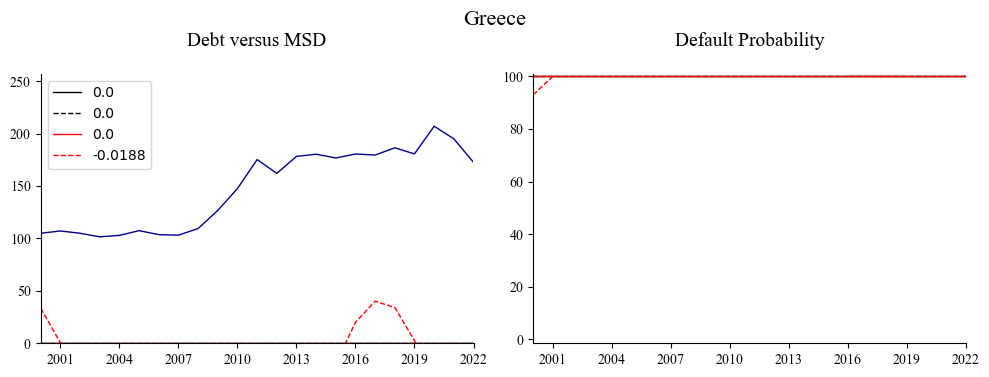

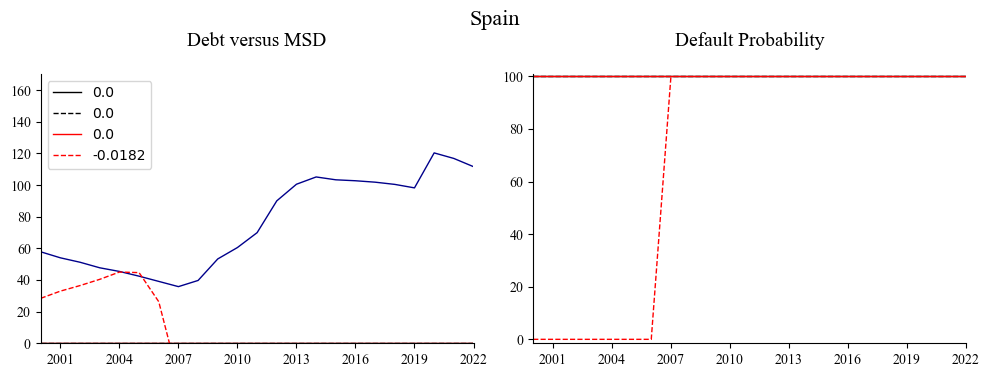

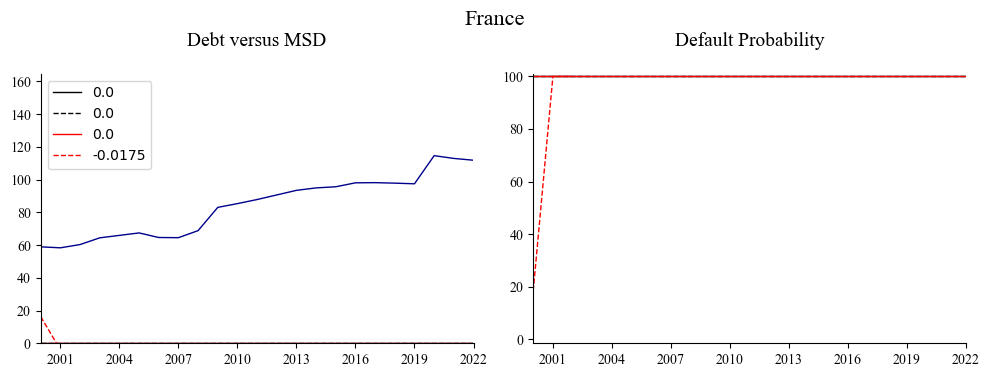

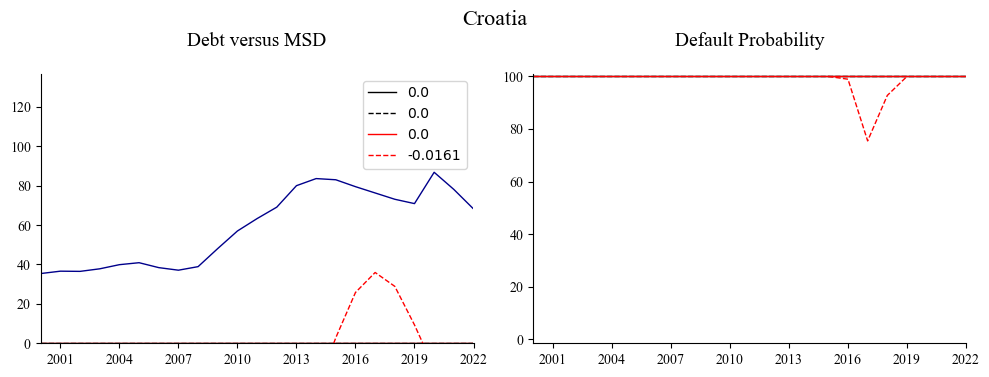

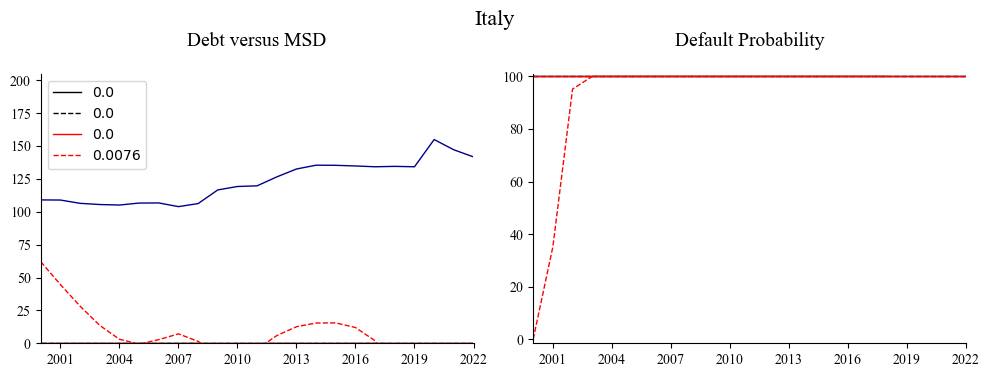

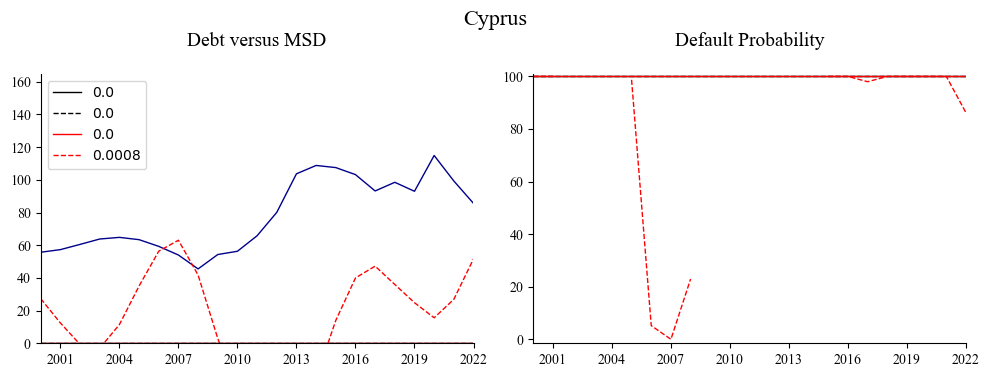

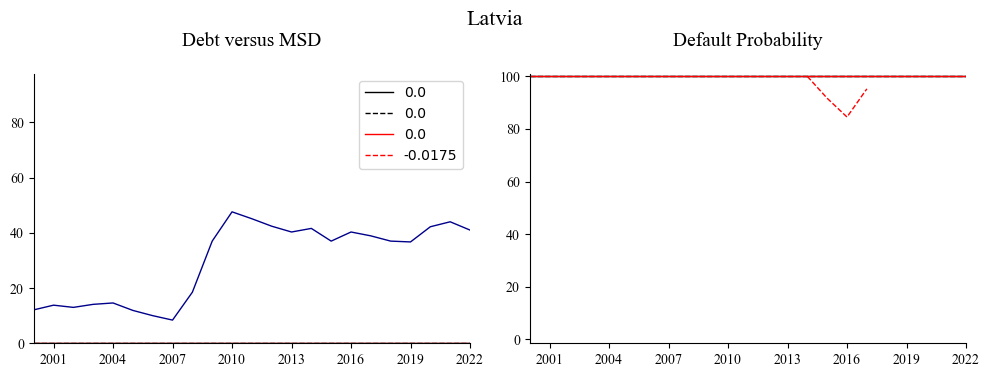

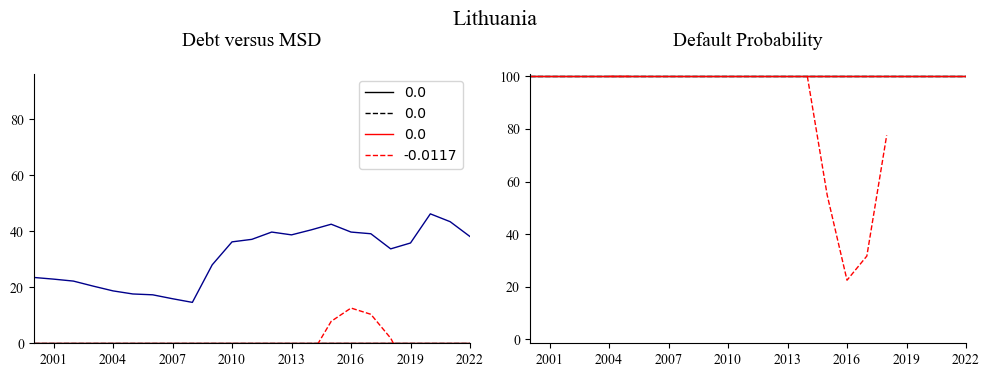

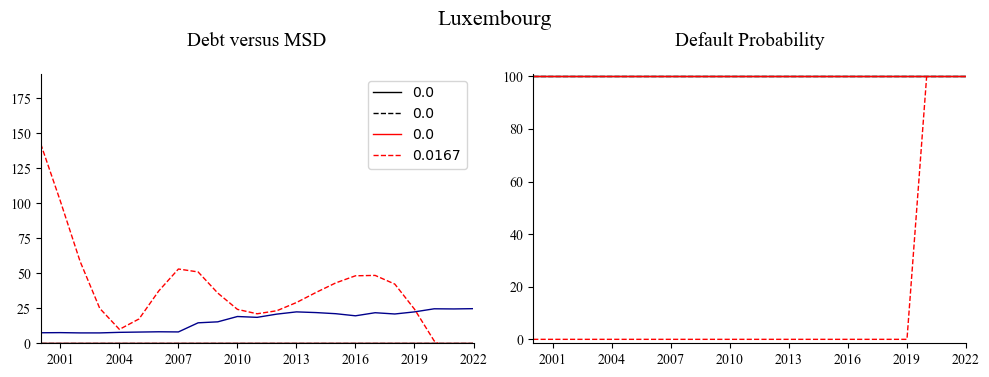

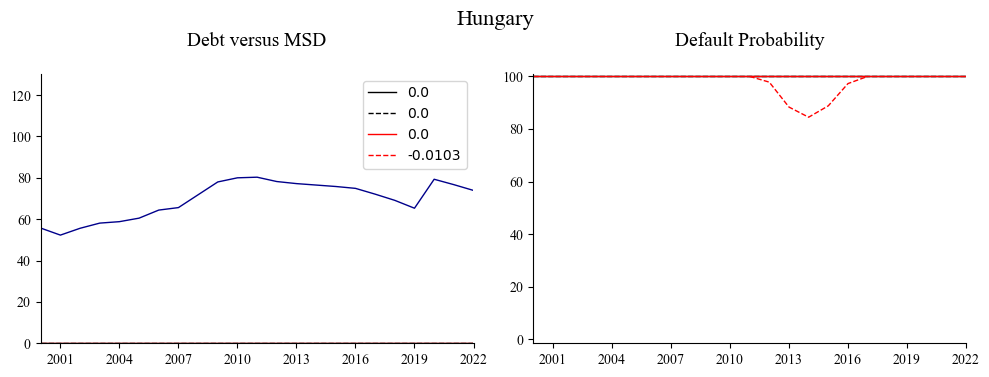

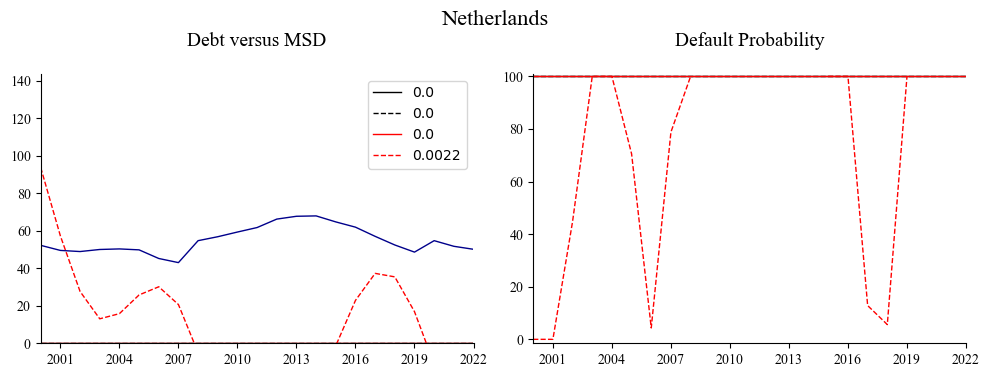

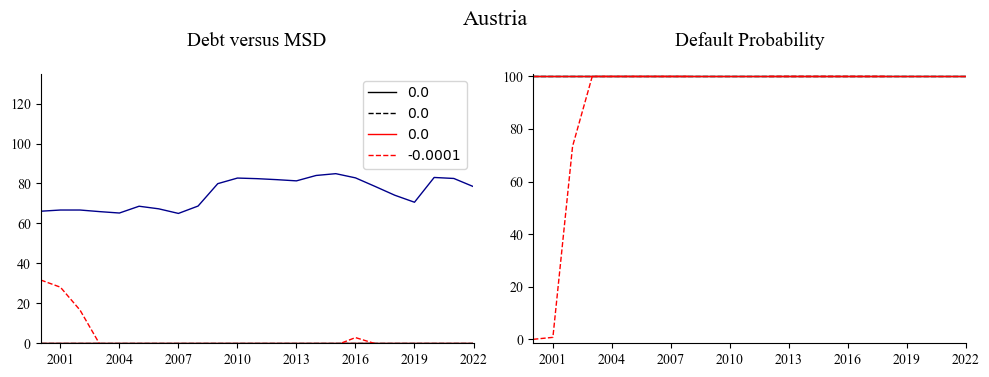

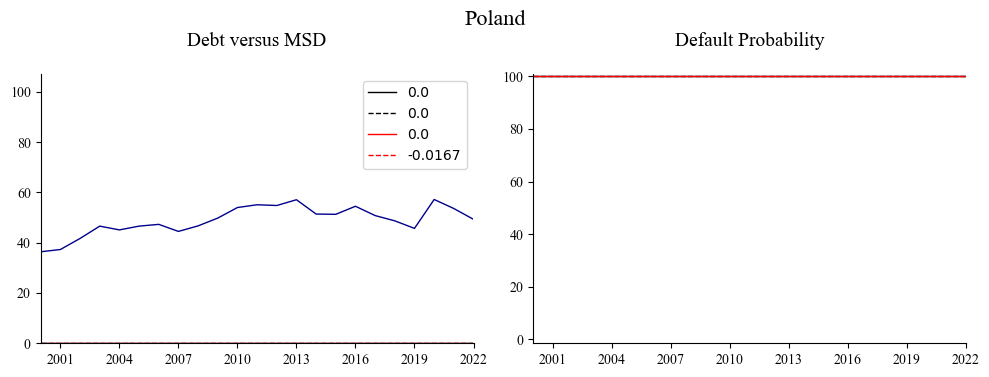

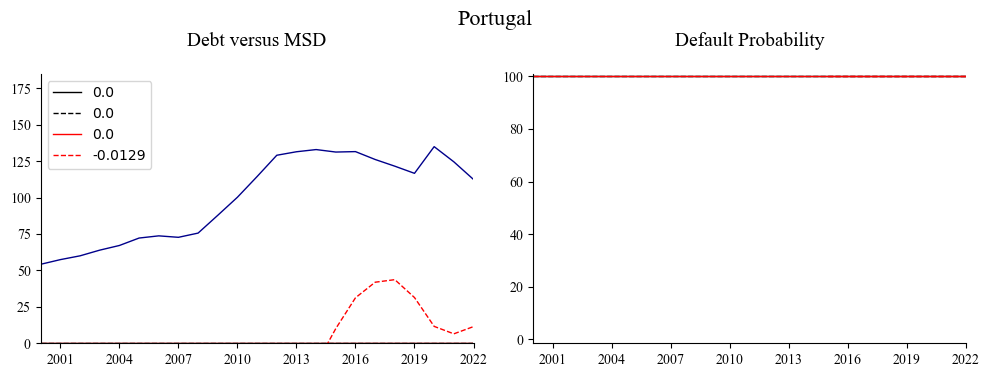

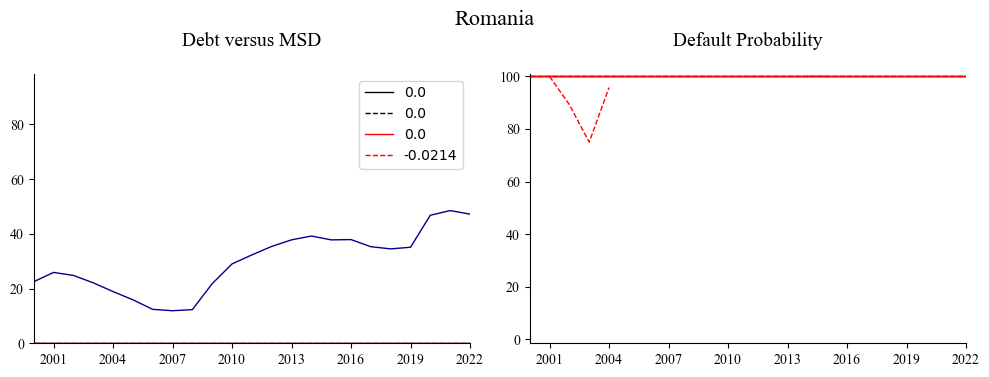

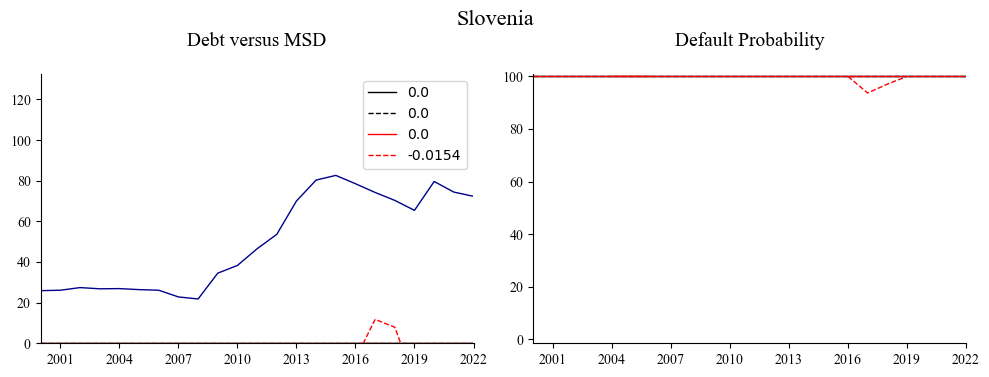

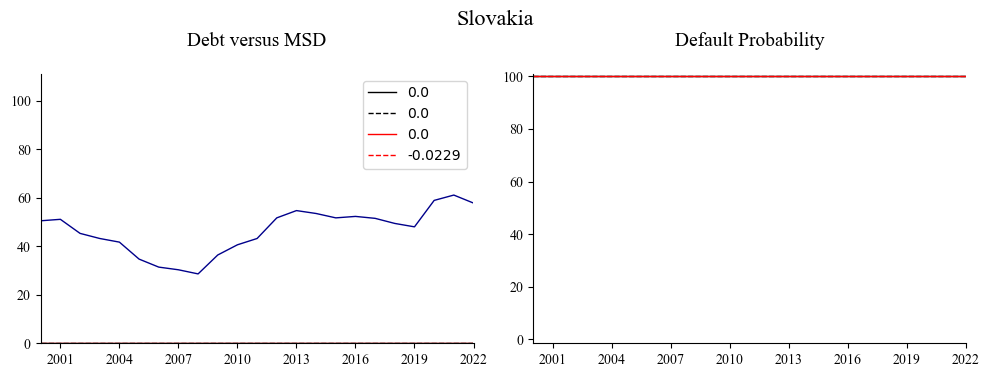

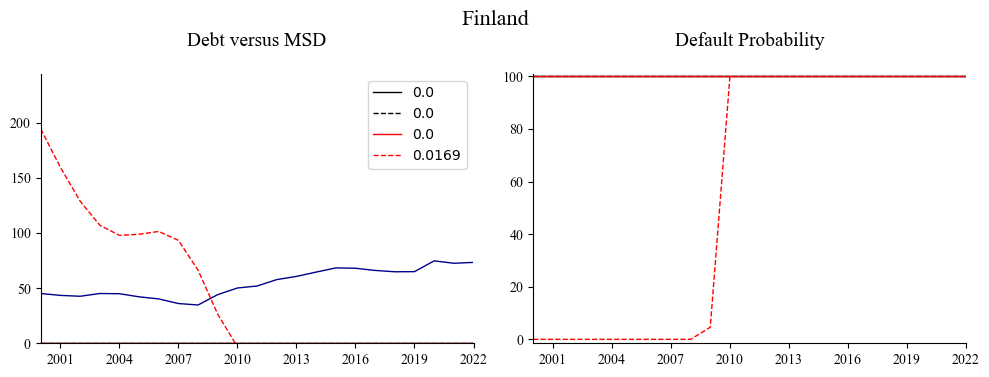

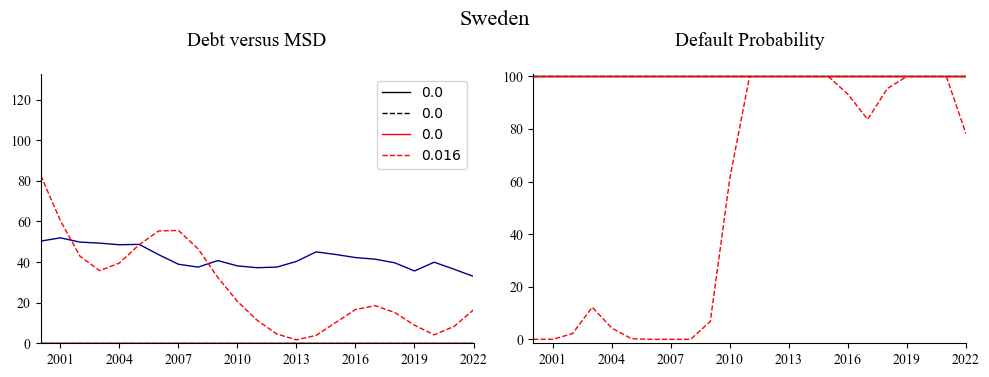

In [180]:
# Plots for each country
Debt_ratio_plot = {}
for i in range(0, len(countries)):
    Debt_ratio_plot[countries[i]] = Debt_ratio[countries[i]]

for i in  range(0, len(countries)): #[19,20,21]: #
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(combined_df[countries[i]]["Year"], Debt_ratio_plot[countries[i]], color='darkblue', linestyle='-',linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_0)"],          label=f"{round(np.mean(alpha_list[0][countries[i]]),4)}", color='black', linestyle='-', linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_1)"].values,   label=f"{round(np.mean(alpha_list[1][countries[i]]),4)}", color='black', linestyle='--',linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_2)"].values,   label=f"{round(np.mean(alpha_list[2][countries[i]]),4)}", color='red', linestyle='-',linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_3)"].values,   label=f"{round(np.mean(alpha_list[3][countries[i]]),4)}",color='red', linestyle='--', linewidth=1)
    
    maximum = max(max(combined_df[countries[i]]["MSD (Alpha_0)"]),
                  max(combined_df[countries[i]]["MSD (Alpha_1)"]),
                  max(combined_df[countries[i]]["MSD (Alpha_2)"]),
                  max(combined_df[countries[i]]["MSD (Alpha_3)"]),
                  max(Debt_ratio_plot[countries[i]]))

    axs[0].set_ylim(0, maximum+50)

    axs[0].set_xlim(T_0_new, T_new)
    axs[0].set_title("Debt versus MSD", fontname='Times New Roman', size=14, pad=20)
    axs[0].tick_params(axis='x', labelsize=10)
    axs[0].tick_params(axis='y', labelsize=10)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['right'].set_color('none')
    axs[0].yaxis.tick_left()
    axs[0].spines['bottom'].set_position('zero')
    axs[0].spines['top'].set_color('none')
    axs[0].xaxis.tick_bottom()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].legend("upper left")

    for label in axs[0].get_yticklabels():
        label.set_fontproperties(font_props)

    for label in axs[0].get_xticklabels():
        label.set_fontproperties(font_props)

    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_0)"], label='Probability_of_default (Alpha_0)',  color='black', linestyle='-',linewidth=1)
    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_1)"], label='Probability_of_default (Alpha_1)' ,  color='black', linestyle='--',linewidth=1)
    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_2)"], label='Probability_of_default (Alpha_2)',  color='red', linestyle='-',linewidth=1)
    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_3)"], label='Probability_of_default (Alpha_3)' ,  color='red', linestyle='--',linewidth=1)
    axs[1].set_title("Default Probability", fontname='Times New Roman', size=14)
    axs[1].tick_params(axis='x', labelsize=10)
    axs[1].tick_params(axis='y', labelsize=10)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_ylim(-1.5, 101)
    axs[1].set_xlim(T_0_new, T_new)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].legend()
    for label in axs[1].get_yticklabels():
        label.set_fontproperties(font_props)

    for label in axs[1].get_xticklabels():
        label.set_fontproperties(font_props)

    plt.title("Default Probability", fontname='Times New Roman', size=14, pad=20)
    fig.suptitle(f"{countries[i]}", fontname='Times New Roman', size=16, weight='normal', y=0.93)

    plt.tight_layout()

    if Save_plots == True:
        plt.savefig(f"{path}/plot_output_x_{i}.pdf", bbox_inches='tight', transparent=True)
    
    if Close_plots == True:
        plt.close(plt.gcf())
    else:
        plt.show()

******
<h2><center>Tables</center></h2>

******

In [181]:
# for i in range(len(countries)):
#     print(f"{countries[i]:15s} & {Var_output[i,0]:6.2f} & {Var_output[i,1]:6.2f} & {Var_output[i,2]:6.2f} & {Var_output[i,3]:6.2f} \\\\")

In [182]:
# selected_df = df_resm.iloc[:, [0,1,2,3,4,6,7,8,9,10,11]]
# latex_output = selected_df.to_latex(float_format="%.2f")
# print(latex_output)

In [183]:
# selected_df = df_resb.iloc[:, [0,1,2,3,4,6,7,8,9,10,11]]
# latex_output = selected_df.to_latex(float_format="%.2f")
# print(latex_output)

In [184]:
# selected_df = df_resm.iloc[:, [0, 3, 6, 9]]
# latex_output = selected_df.to_latex(float_format="%.2f")
# print(latex_output)